This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1673]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os
from importlib import reload

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml
import gradstuff as gds
import statstuff as sts
import fourierstuff as fs
import retrievestuff as rs

In [1674]:
%matplotlib notebook

In [1675]:
# Display parameters
azim=-120
elev=40

In [1676]:
# Define the variance in the observations (BS units^2)
noiseamp = 5**2
noisestd = noiseamp**.5
print('Std deviation in observed (Se^.5) is', noisestd)
realnoise = 5
print('Real noise will be', realnoise)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0
print('Std deviation in a priori (Sa^.5) is', apriorivar0**.5)

Std deviation in observed (Se^.5) is 5.0
Real noise will be 5
Std deviation in a priori (Sa^.5) is 15.0


In [1677]:
# Read and unpack the calibration data
Calibration=f90nml.read('Calibration.nml') #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

In [1678]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [1679]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes

In [1680]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
fbs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [1681]:
def create_surface1():
    # Creates a sloped plane; arg is not used
    Truenx = 35; Trueny = 36; dx = dy = 0.66
    Truesolution = np.zeros((Trueny,Truenx))
    slopey = 0.0
    slopex = 0.0
    for ix in range(Truenx):
        for iy in range(Trueny):
            Truesolution[iy,ix] += iy*slopey*dy
    for ix in range(Truenx):
        for iy in range(Trueny):
            Truesolution[iy,ix] += ix*slopex*dx
    #print(np.shape(Truesolution))
    ymax = dy*(Trueny-1)
    xmax = dx*(Truenx-1)
    surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
    surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
    surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)

def create_surface2():
    # Creates a surface based on a bunch of sines and cosines; arg is not used
    Truenx = 29; Trueny = 49; dx = dy = 0.66
    height = 0.00005
    ymax = dy*(Trueny-1)
    xmax = dx*(Truenx-1)
    surf_ytot = np.linspace(0,ymax,Trueny); #print(surf_ytot[1]-surf_ytot[0]); 
    surf_xtot = np.linspace(0,xmax,Truenx); #print(surf_xtot[1]-surf_xtot[0]); 
    surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
    lambdax1 = 5; kx1 = np.pi*2/lambdax1
    lambdax2=  7; kx2 = np.pi*2/lambdax2
    lambdax3=  10; kx3 = np.pi*2/lambdax3
    lambday1 = 7; ky1 = np.pi*2/lambday1
    lambday2 = 8; ky2 = np.pi*2/lambday2  
    lambday3 = 9; ky3 = np.pi*2/lambday3  
    term1 = np.cos(kx1*surf_xgridtot) + np.sin(ky1*surf_ygridtot)
    term2 = np.sin(kx2*surf_xgridtot) + np.cos(ky2*surf_ygridtot)
    term3 = np.cos(kx3*(surf_xgridtot+surf_xgridtot) + np.sin(ky3*(surf_ygridtot+surf_xgridtot)))
    Truesolution = (term1*term2+term3)*height
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution)

def create_surface3():
    # A surface retrieved from observations; arg is used to indicate the segment desired
    flattenedfile = np.load('../crystals/2019-08-02/case1.1/Segments1_compr_flat_filt.npz')
    isegment = 11
    stlfilename = 'Segments1_compr_flat_filt_'+str(isegment)+'_vx5_remade.stl'; print(stlfilename)
    xgridtot = flattenedfile['xgridtot']
    ygridtot = flattenedfile['ygridtot']
    zgridtot = flattenedfile['zgridtot']
    Truesolution = zgridtot[isegment]
    surf_xgridtot = xgridtot[isegment]; dx = surf_xgridtot[0,1]-surf_xgridtot[0,0]; print('dx', dx)
    surf_ygridtot = ygridtot[isegment]; dy = surf_ygridtot[1,0]-surf_ygridtot[0,0]; print('dy', dy)
    Trueny, Truenx = np.shape(Truesolution); print(Truenx, Trueny)
    return (Truenx, Trueny, dx, dy, surf_xgridtot, surf_ygridtot, Truesolution, stlfilename)

Segments1_compr_flat_filt_11_vx5_remade.stl
dx 0.6614583000000067
dy 0.6614583000000014
49 29
std dev of height 0.0019002267882436508


<IPython.core.display.Javascript object>


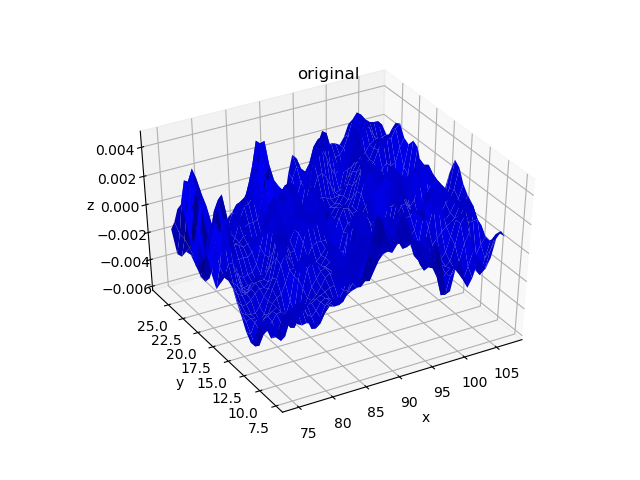

Text(0.5,0.92,'original')

In [1682]:
# Make the surface
surfacedata = create_surface3()
Truenx = surfacedata[0]
Trueny = surfacedata[1]
dx = surfacedata[2]
dy = surfacedata[3]
surf_xgridtot = surfacedata[4]
surf_ygridtot = surfacedata[5]
Truesolution = surfacedata[6]*.01; Z2maxforhist = .2 # Very low input relief
#Truesolution = surfacedata[6]; Z2maxforhist = .15  # Moderate input relief
#Truesolution = surfacedata[6]*5; Z2maxforhist = 2   # High input relief


# A little reporting
print('std dev of height', np.std(Truesolution))

# Extract axes
surf_ytot = surf_ygridtot[:,0]; #print(surf_ytot)
surf_xtot = surf_xgridtot[0,:]; #print(surf_xtot)

# Display this surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, Truesolution, color='b')
#ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=azim,elev=elev)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
ax.set_title('original')

In [1683]:
# Create "observed" backscatter intensities from the forward model

# Get gradients of the true solution
surf_dzgrid_dy_retrieved = np.diff(Truesolution,axis=0)/dy
surf_dzgrid_dx_retrieved = -np.diff(Truesolution,axis=1)/dx

# Generate "observed" backscatter intensities
bigKx = np.matrix(np.empty((4,0)), copy=False)
bigKy = np.matrix(np.empty((4,0)), copy=False)
bigc_last = np.matrix(np.empty((4,0)), copy=False)
for iy in range(Trueny-1):
    for ix in range(Truenx-1):
        dzdx = surf_dzgrid_dx_retrieved[iy,ix]; #print('dzdx =', dzdx)
        dzdy = surf_dzgrid_dy_retrieved[iy,ix]; #print('dzdy =', dzdy)
        nxy_last = np.vstack((dzdx,dzdy))
        K_i, c_last = fbs.getK(nxy_last,
        Arule, Brule, Crule, Drule,
        KAxrule, KAyrule,
        KBxrule, KByrule,
        KCxrule, KCyrule,
        KDxrule, KDyrule)
        bigKx = np.hstack((bigKx,K_i[:,0]))
        bigKy = np.hstack((bigKy,K_i[:,1]))
        bigc_last = np.hstack((bigc_last,c_last))
cA_orig = np.reshape(bigc_last[0],(Trueny-1,Truenx-1))
cB_orig = np.reshape(bigc_last[1],(Trueny-1,Truenx-1))
cC_orig = np.reshape(bigc_last[2],(Trueny-1,Truenx-1))
cD_orig = np.reshape(bigc_last[3],(Trueny-1,Truenx-1))
ny,nx = cA_orig.shape; 
print(ny,nx)

28 48


In [1684]:
# Add some noise to the observed signals
cA = cA_orig + np.random.randn(ny,nx)*realnoise
cB = cB_orig + np.random.randn(ny,nx)*realnoise
cC = cC_orig + np.random.randn(ny,nx)*realnoise
cD = cD_orig + np.random.randn(ny,nx)*realnoise
print(np.std(cA))
print(np.max(cA))
print(np.min(cA))

5.17276533354477
144.372304974603
113.82095524329073


<IPython.core.display.Javascript object>


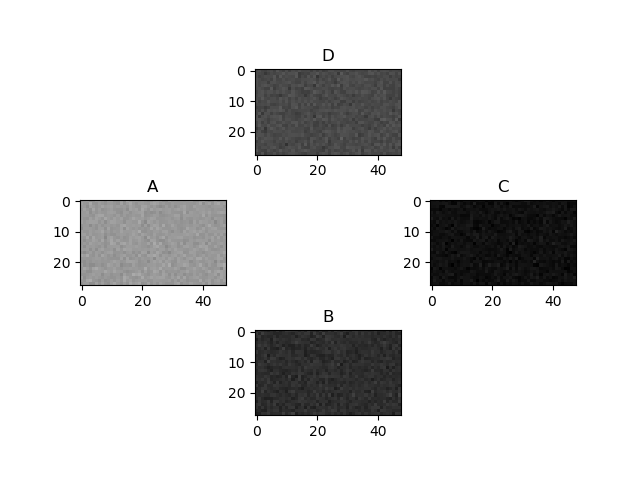

Text(0.5,1,'D')

In [1685]:
plt.figure()
vmin = 0; vmax = 255
plt.subplot(334); plt.imshow(np.asarray(cA), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('A')
plt.subplot(338); plt.imshow(np.asarray(cB), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('B')
plt.subplot(336); plt.imshow(np.asarray(cC), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('C')
plt.subplot(332); plt.imshow(np.asarray(cD), cmap = 'Greys_r', vmin = vmin, vmax = vmax); plt.title('D')

In [1699]:
# Loop to evaluate the information content in each segment
print('Correlating detectors A-D for each segment')
cseg = [cA,cB,cC,cD]
infoscore = sts.getinfoscore(cseg)
print('Correlation score =', infoscore)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(ny,nx)*100*3)
print('')

Correlating detectors A-D for each segment
0 1 2.5981471107075844
0 2 -1.3181190439328951
0 3 -0.5200522821243629
1 2 3.4457013973166086
1 3 -2.2114136699356663
2 3 -2.854860866308046
Correlation score = 5.802732089630245
Benchmark score for random signals = 8.292528443835984



In [1687]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [1688]:
# Generic retrieval parameters
maxiter = 6
tolerance = 10

In [1689]:
# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

In [1690]:
# Retrieve 

# Construct gradients
Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
Ny = Ny_unscaled/dy
Nx = -Nx_unscaled/dx #fixing x inversion

# Number of observations
nobs = (nx-1)*(ny-1)*4; #print(nobs)

# Number of desired points (heights)
nzpts = ny*nx-1; print(nzpts)

# Extract the a priori variance
vartemp = apriorivar[0:ny,0:nx]
vartemp_long = np.reshape(vartemp,nzpts+1,0)
Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)

# Extract the starting z
settemp = copy.copy(solution)
settemp_long = np.reshape(settemp,nzpts+1,0)
settemp_longminus1 = settemp_long[:-1]
z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
z_start = z_start*0.0; #print "aprioriset", shape(z_start)

# Construct the variance in observation + model
Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

# Do the retrieval
print('')
z_retrieved = fbs.retrievesegment(\
0,0,nx-1,ny-1,cA,cB,cC,cD,\
Sa,Se,z_start,maxiter,tolerance,\
Nx,Ny,\
Arule, Brule, Crule, Drule,\
KAxrule, KAyrule, \
KBxrule, KByrule, \
KCxrule, KCyrule, \
KDxrule, KDyrule)
solution = copy.copy(z_retrieved)

1343

Observed intensities (detector B):
mean, max, min = 38.318085661880176 52.98557091190315 23.990339982952065
<diff>, std(diff), di2 = 0.040396108266041064 5.015735498858442 1381.926099612396
<diff>, std(diff), di2 = -0.024182797113385716 4.292860688976352 20.6112110713805
<diff>, std(diff), di2 = -0.019629501925128023 4.279183678078733 2.059122781673574


In [1691]:
# Shorten the grids to match the solution
surf_xgrid = surf_xgridtot[0:-1,0:-1]
surf_ygrid = surf_ygridtot[0:-1,0:-1]

# Re-level to match the true solution as closely as possible
shift = np.mean(Truesolution[0:-1,0:-1]-solution); #print(shift)
solution += shift

<IPython.core.display.Javascript object>


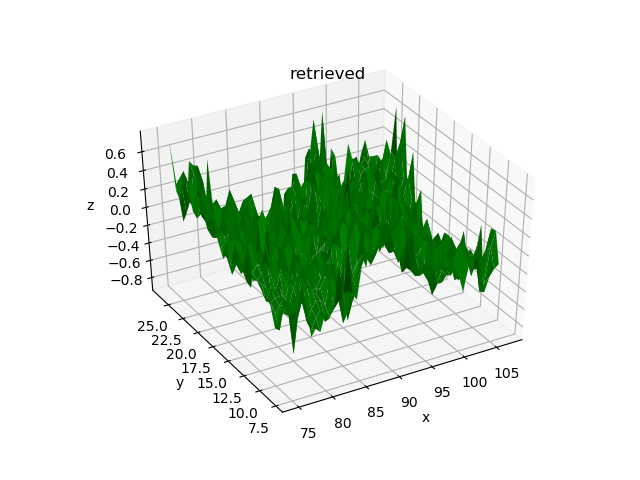

std error = 0.2314318072468771
std dev of height = 0.2314832588344989


In [1692]:
# Show the reconstructed surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgrid, surf_ygrid, solution, color='g')
#ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(azim=azim,elev=elev)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_zlim(zlim)
ax.set_title('retrieved')

difference = np.std(solution-Truesolution[0:-1,0:-1]); print('std error =', difference)
variability = np.std(solution); print('std dev of height =', variability)

lambda cutting off at 2.5132741228718345 um
(28, 48)


<IPython.core.display.Javascript object>


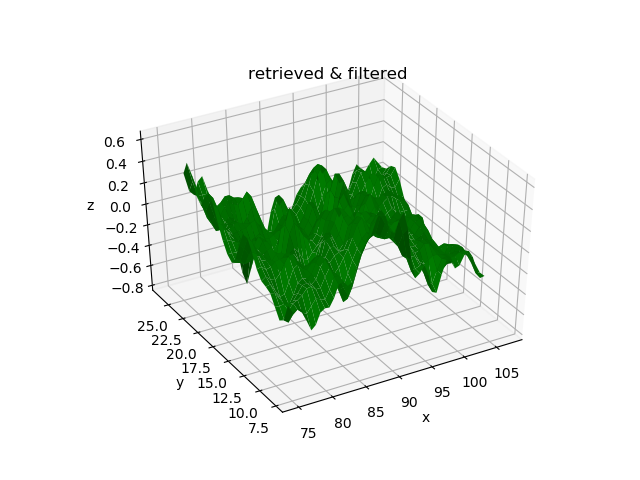

(6.916948875952579, 27.28986451595259)

In [1693]:
# Fourier transform & filter

# Set the low-pass threshold
kmax = 2.5
print('lambda cutting off at', np.pi*2/kmax, 'um')

# Do the filtering
solution_filtered = fs.filterseg(kmax,surf_xgrid,surf_ygrid,solution)[0]; print(np.shape(solution_filtered))

# Get rid of the edges
surf_xgrid_truncated = surf_xgrid[1:-2,1:-2]
surf_ygrid_truncated = surf_ygrid[1:-2,1:-2]
Retrsolution = solution_filtered[1:-2,1:-2]

# Graphing the filtered surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgrid_truncated, surf_ygrid_truncated, Retrsolution, color='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('retrieved & filtered')
ax.view_init(azim=azim,elev=elev)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_zlim(zlim)

<IPython.core.display.Javascript object>


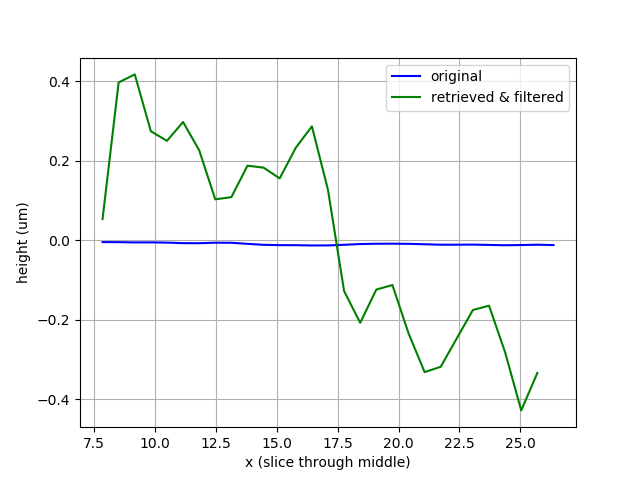

In [1694]:
# Show a slice of the reconstructed surface
plt.figure()
midpt = int(nx/2)
shift = np.mean(solution[:,midpt])-np.mean(Truesolution[:,midpt])
plt.plot(surf_ytot,Truesolution[:,midpt]+shift, color='b', label='original')
plt.plot(surf_ytot[0:-1],np.array(solution_filtered[:,midpt]), color='g', label='retrieved & filtered')
plt.xlabel('x (slice through middle)')
plt.ylabel('height (um)')
plt.grid(True)
plt.legend()

Z2 ranging from 0.0 to 0.2
Max number of bins specified is 8
Using levels = 3 for uncertainty analysis
Sturges rule says maxbins = 11
Using nbins =  8
Original =  1344
4 0 336 [336   0   0   0   0   0   0]
4 1 336 [336   0   0   0   0   0   0]
4 2 336 [336   0   0   0   0   0   0]
4 3 336 [336   0   0   0   0   0   0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
True meanZ2 =  3.109153754663716e-06
True statsigma =  0.0017632792616780009
Original =  1056
4 0 264 [164  52  26  10   3   4   1]
4 1 264 [157  64  25  15   3   0   0]
4 2 264 [166  57  20  11   5   2   1]
4 3 264 [159  62  27   7   2   4   0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
Retr meanZ2 =  0.031960662572082126
Retr statsigma =  0.17877545293490973
integral =  0.01972984036021285


<IPython.core.display.Javascript object>


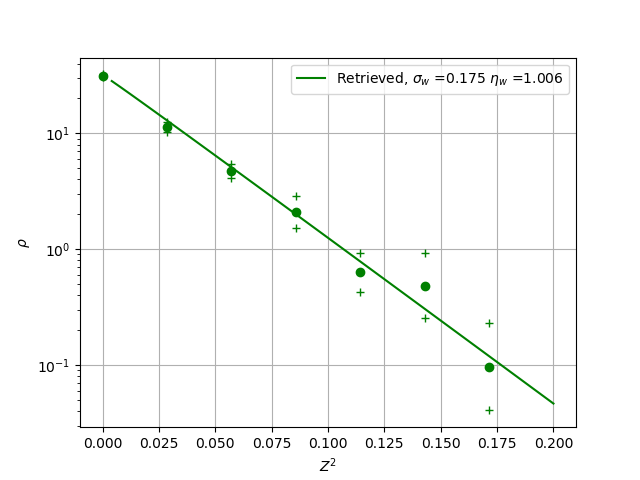

Based on bins: sigmaW, etaW of retrieved/filtered =  0.17557922306574378 1.006536295623365


In [1695]:
# Get the probability distributions in Z2

# Parameters
Z2minforhist = 0.0; print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
Z2offset = 0.0001
nbins_max = 8; print('Max number of bins specified is', nbins_max)
levels = 3; print('Using levels =', levels, 'for uncertainty analysis')
Ntot = np.size(Truesolution)
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
x0 = np.array([.1,.9])

# Get the probability for the original
Truecounts, bins, TruemeanZ2, TrueZ2flat, Trueerror = rs.getrhoofz2(Truesolution,dx,dy,Z2bins=Z2bins,levels=levels)
print('True meanZ2 = ', TruemeanZ2)
print('True statsigma = ', np.sqrt(TruemeanZ2))
if (np.sqrt(TruemeanZ2) > .02):
    AnalyzeTrue = True
else:
    AnalyzeTrue = False
if AnalyzeTrue:
    Trueintegral_rho = np.trapz(Truecounts, bins); print('integral = ', Trueintegral_rho)
    Truecounts = Truecounts/Trueintegral_rho
    Trueerror = Trueerror/Trueintegral_rho
    Truecountsplus = Truecounts+Trueerror; 
    Truecountsminus = Truecounts**2/Truecountsplus; 

# Get the probability for the retrieved
Retrcounts, bins, RetrmeanZ2, RetrZ2flat, Retrerror = rs.getrhoofz2(Retrsolution,dx,dy,Z2bins=Z2bins,levels=levels)
print('Retr meanZ2 = ', RetrmeanZ2)
print('Retr statsigma = ', np.sqrt(RetrmeanZ2))
Retrintegral_rho = np.trapz(Retrcounts, bins); print('integral = ', Retrintegral_rho)
Retrcounts = Retrcounts/Retrintegral_rho
Retrerror = Retrerror/Retrintegral_rho
Retrcountsplus = Retrcounts+Retrerror; 
Retrcountsminus = Retrcounts**2/Retrcountsplus; 

# Graph the probabilities
plt.figure()
if AnalyzeTrue:
    plt.semilogy(bins, Truecounts, 'ob')
plt.semilogy(bins, Retrcounts, 'og')

# Attempt a best-fit based on the bins for the original
if AnalyzeTrue:
    Trueerrors = np.log(Truecountsplus/Truecounts); #print(errors)
    Truesol, Truesolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Truecounts),x0,sigma=Trueerrors)
    TrueetaW = Truesol[1]
    Truesigma2W = Truesol[0]
    TruesigmaW = np.sqrt(Truesigma2W)
    print('Based on bins: sigmaW, etaW of original = ', TruesigmaW, TrueetaW)

# Attempt a best-fit based on the bins for the original
Retrerrors = np.log(Retrcountsplus/Retrcounts); #print(errors)
Retrsol, Retrsolerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(Retrcounts),x0,sigma=Retrerrors)
RetretaW = Retrsol[1]
Retrsigma2W = Retrsol[0]
RetrsigmaW = np.sqrt(Retrsigma2W)
print('Based on bins: sigmaW, etaW of retrieved/filtered = ', RetrsigmaW, RetretaW)

if AnalyzeTrue:
    # Graph the best-fit probability
    myWeibull = sts.Weibull(Z2theory,Truesigma2W,TrueetaW)
    plt.semilogy(Z2theory, myWeibull, 'b',label = 'Original, $\sigma_w$ =' + str(TruesigmaW)[0:5] + ' $\eta_w$ =' + str(TrueetaW)[0:5])

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,Retrsigma2W,RetretaW)
plt.semilogy(Z2theory, myWeibull, 'g',label = 'Retrieved, $\sigma_w$ =' + str(RetrsigmaW)[0:5] + ' $\eta_w$ =' + str(RetretaW)[0:5])

# Add the error bars
if AnalyzeTrue:
    plt.semilogy(bins, Truecountsplus, '+b')
    plt.semilogy(bins, Truecountsminus,'+b')
plt.semilogy(bins, Retrcountsplus, '+g')
plt.semilogy(bins, Retrcountsminus,'+g')

# Labels, etc
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)
plt.legend()


# Results:

#### When the input structure is flat (relief~.01 um):  
-If the noise is low (like 1 BSU), the correlation score ranges from 5-10. The roughness is Gaussian and low, but non-zero (like sigmaW = .03). The std height error is around .04 um, with a retrieved discrepancy of std(diff)=0.8 BSU. Setting the GNBF observation estimate (Se) to a higher value than the noise (like Se^.5 = 3 BSU when noise = 1 BSU) yields similar results.  
-If the noise is high (like 5), the correlation score is around 5, and the retrieval produces a surface with significant "phantom" relief, like 0.2 um. The roughness is Gaussian, and unrealistically high (like sigmaW = .2).  The retrieved discrepancy is std(diff) = 4 BSU.   
-If the noise is very high (like 10 BSU), the correlation score is around 5, the roughness is Gaussian, and absurdly high (like sigmaW = 1).  


Conclusions: A *low* correlation score (compared to the random benchmark, here about 8) generally means a bad retrieval. Also, we need noise on the order of 1 BSU to avoid creating phantom structure large enough to impact sigmaW. 

#### When the input structure is moderately rough (relief~.2 um) :  
-If the noise is low (like 1 BSU), the correlation score rises to as high as 70, the roughness is Gaussian, and matches the input roughness to within 0.01 (like sigmaW = .19 vs .18). The std height error is around .04 um, with a retrieved discrepancy std(diff) = 0.9 BSU.  
-If the noise is high (like 5 BSU), the correlation score drops back to around 5, the roughness is Gaussian, and exceeds the input roughness significantly (like sigmaW = .24 vs .18).  

Conclusions: A *high* correlation score means a good retrieval. We still need noise on the order of 1 BSU to avoid creating phantom structure large enough to impact sigmaW.


#### When the input structure is very rough (relief~1 um) :  
-If the noise is low (like 1 BSU), the correlation score rises to > 100, the roughness is Gaussian, and matches the input roughness well (like sigmaW = .82 vs .81). The std height error is around .07 um, with a retrieved discrepancy std(diff)=0.9 BSU.  
-If the noise is high (like 5 BSU), the correlation score rises to ~50, the roughness is Gaussian, and exceeds the input roughness somewhat (like sigmaW = .9 vs .8). The retrieved discrepancy is std(diff) = 4 BSU.  

Conclusions: A *high* correlation score means a good retrieval. Even noise on the order of 5 BSU does not significantly impact sigmaW.


In [1696]:
# Save an image
#fig.savefig('benchmark.jpg')

# # Save stl files
# vscale = 5
# stlfilename = surfacedata[7]; print(stlfilename)
# #sls.numpy2stl(np.fliplr(sollast_FT_filtered_IFT_real[1:-2,1:-2]), stlfilename, scale=vscale/dx, solid=False)
# sls.numpy2stl(Retrsolution, stlfilename, scale=vscale/dx, solid=False)

In [1697]:
# Compressedfilename = 'benchmarkretrieved.npz'
# print("saving", Compressedfilename)
# np.savez_compressed(Compressedfilename, \
#                     surfaceroot='2018', \
#                     imageroot='2018', \
#                     nx1list=[0], \
#                     nx2list=[nx-1], \
#                     ny1list=[0], \
#                     ny2list=[ny-1], \
#                     pA=pA, \
#                     pB=pB, \
#                     pC=pC, \
#                     pD=pD, \
#                     sA=sA, \
#                     sB=sB, \
#                     sC=sC, \
#                     sD=sD, \
#                     nxi=nxi, \
#                     nyi=nyi, \
#                     dnx=dnx, \
#                     dny=dny, \
#                     solution=solution)

In [1698]:
# # More attempts to understand how the FT works
# import fourierstuff as fs
# x = np.linspace(0,20,50)
# y = np.linspace(0,20,51)
# xgrid,ygrid = np.meshgrid(x,y)
# lambdax = 5; kx = np.pi*2/lambdax; print(kx)
# lambday = 4; ky = np.pi*2/lambday; print(ky)
# sollast = np.sin(kx*xgrid) + np.sin(ky*ygrid)
# Ny, Nx = np.shape(sollast)

# # FT
# sollast_FTshift,kxshift,kyshift = fs.FT(sollast,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 


# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, sollast)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')

# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)
